# 3. Confined Aquifer Test - Sioux Example
**This test is taken from AQTESOLV examples.**

## Introduction and Conceptual Model

In this example, we reproduce the work of Yang (2020) to use the pumping test data to demonstrate how TTim can be used to model and analyze pumping tests in a single layer, confined setting, in multiple piezometers. Furthermore, we compare the performance of TTim with other transient well hydraulics software AQTESOLV (Duffield, 2007) and MLU (Carlson and Randall, 2012).

This example is a pumping test done in Sioux Flats, South Dakota, USA. The data comes from the AQTESOLV documentation (Duffield, 2007).
The aquifer is 50 ft thick and is bounded by impermeable layers. The test was conducted for 2045 minutes (~34 hours), with a constant pumping rate of 2.7 $ft^3/s$. Drawdown data has been collected at three piezometers located 100, 200 and 400 ft away, respectively. The well radius is 0.5 ft.

We can resume the conceptual model in the picture below:

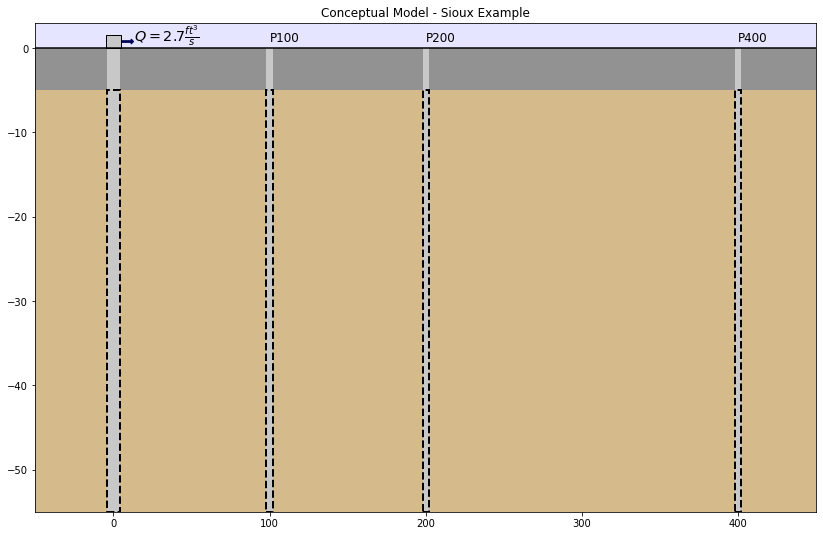

In [1]:
import matplotlib.pyplot as plt
import numpy as np

##Now printing the conceptual model figure:

fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(1,1,1)
#sky
sky = plt.Rectangle((-50,0), width = 500, height = 3, fc = 'b', zorder=0, alpha=0.1)
ax.add_patch(sky)

#Aquifer:
ground = plt.Rectangle((-50,-55), width = 500, height = 50, fc = np.array([209,179,127])/255, zorder=0, alpha=0.9)
ax.add_patch(ground)

#Confining bed:
confining_unit = plt.Rectangle((-50,-5), width = 500, height = 5, fc = np.array([100,100,100])/255, zorder=0, alpha=0.7)
ax.add_patch(confining_unit)
well = plt.Rectangle((-4,-55), width = 8, height = 55, fc = np.array([200,200,200])/255, zorder=1)
ax.add_patch(well)

#Wellhead
wellhead = plt.Rectangle((-5,0),width = 10, height = 1.5, fc = np.array([200,200,200])/255, zorder=2, ec='k')
ax.add_patch(wellhead)

#Screen for the well:
screen = plt.Rectangle((-4,-55), width = 8, height = 50, fc = np.array([200,200,200])/255, alpha=1, zorder = 2, ec = "k", ls = '--')
screen.set_linewidth(2)
ax.add_patch(screen)
pumping_arrow = plt.Arrow(x = 5,y = 0.75, dx = 8, dy = 0, color = "#00035b")
ax.add_patch(pumping_arrow)
ax.text(x = 13, y = 0.75, s = r'$ Q = 2.7 \frac{ft^3}{s}$', fontsize = 'x-large' )
#Piezometers
piez1 = plt.Rectangle((98,-55), width = 4, height = 55,fc = np.array([200,200,200])/255, zorder=1)
piez2 = plt.Rectangle((198,-55), width = 4, height = 55,fc = np.array([200,200,200])/255, zorder=1)
piez3 = plt.Rectangle((398,-55), width = 4, height = 55,fc = np.array([200,200,200])/255, zorder=1)

screen_piez_1 = plt.Rectangle((98,-55), width = 4, height = 50, fc = np.array([200,200,200])/255, alpha=1, zorder = 2, ec = "k", ls = '--')
screen_piez_1.set_linewidth(2)
screen_piez_2 = plt.Rectangle((198,-55), width = 4, height = 50, fc = np.array([200,200,200])/255, alpha=1, zorder = 2, ec = "k", ls = '--')
screen_piez_2.set_linewidth(2)
screen_piez_3 = plt.Rectangle((398,-55), width = 4, height = 50, fc = np.array([200,200,200])/255, alpha=1, zorder = 2, ec = "k", ls = '--')
screen_piez_3.set_linewidth(2)
ax.add_patch(piez1)
ax.add_patch(piez2)
ax.add_patch(piez3)
ax.add_patch(screen_piez_1)
ax.add_patch(screen_piez_2)
ax.add_patch(screen_piez_3)
#last line
line = plt.Line2D(xdata= [-50,500], ydata = [0,0], color = "k")
ax.add_line(line)
ax.text(x = 100, y = 0.75, s = 'P100', fontsize = 'large' )
ax.text(x = 200, y = 0.75, s = 'P200', fontsize = 'large' )
ax.text(x = 400, y = 0.75, s = 'P400', fontsize = 'large' )
ax.set_xlim([-50,450])
ax.set_ylim([-55,3])
ax.set_title('Conceptual Model - Sioux Example');

## Step 1. Load Required Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ttim import *

## Step 2. Set basic parameters

- We will work with time in days and length in meters from this step onwards
- The parameters below have already been converted to m and days.

In [3]:
Q = 6605.754 #constant discharge in m^3/d
b = -15.24 #aquifer thickness in m
rw = 0.1524 #well radius in m
r1 = 30.48 #distance between obs1 to pumping well
r2 = 60.96 #distance between obs2 to pumping well
r3 = 121.92 #distance between obs3 to pumping well

## Step 3. Load data of observation and pumping well

The preferred method of loading data into TTim is to use numpy arrays.

The data is in a text file where the first column is the time data in ***days*** and the second column is the drawdown in ***meters***

For each piezometer, we will load the data as a numpy array. We further split the data into two different 1d arrays, one for time and another for drawdown.

In [4]:
data1 = np.loadtxt('data/sioux100.txt')
t1 = data1[:, 0]
h1 = data1[:, 1]


data2 = np.loadtxt('data/sioux200.txt')
t2 = data2[:, 0]
h2 = data2[:, 1]

data3 = np.loadtxt('data/sioux400.txt')
t3 = data3[:, 0]
h3 = data3[:, 1]


<a id='step_4'></a>
## Step 4. Creating a TTim conceptual model

In this example, we are using the ModelMaq model to conceptualize our aquifer. ModelMaq defines the aquifer system as a stacked vertical sequence of aquifers and leaky layers (aquifer-leaky layer, aquifer-leaky layer, etc). A thorough explanation of the ModelMaq and TTim one-layer modelling conceptualization is given in the notebook: [Confined 1 - Oude Korendijk](confined1_oude_korendijk)

In [5]:
ml_0 = ModelMaq(kaq=10, z=[0, b], Saq=0.001, tmin=0.001, tmax=10, topboundary='conf')
w_0 = Well(ml_0, xw=0, yw=0, rw=rw, tsandQ=[(0, Q)], layers = 0)
ml_0.solve()

self.neq  1
solution complete


## Step 5. Calibration

The calibration workflow has been described in detail in the notebook: [Confined 1 - Oude Korendijk](confined1_oude_korendijk)

### Step 5.1. Model Calibration with all observation wells

We calibrate the model with all observation wells.
We begin by assuming no wellbore storage or skin resistance, and we only calibrate the hydraulic conductivity and specific storage

In [6]:
#unknown parameters: k, Saq
ca_0 = Calibrate(ml_0)
ca_0.set_parameter(name='kaq0', initial=10)
ca_0.set_parameter(name='Saq0', initial=1e-4)
ca_0.series(name='obs1', x=r1, y=0, t=t1, h=h1, layer=0)
ca_0.series(name='obs2', x=r2, y=0, t=t2, h=h2, layer=0)
ca_0.series(name='obs3', x=r3, y=0, t=t3, h=h3, layer=0)
ca_0.fit(report=True)

.....................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 77
    # variables        = 2
    chi-square         = 0.00121634
    reduced chi-square = 1.6218e-05
    Akaike info crit   = -847.289973
    Bayesian info crit = -842.602362
[[Variables]]
    kaq0:  282.795267 +/- 1.13790635 (0.40%) (init = 10)
    Saq0:  0.00420855 +/- 3.3461e-05 (0.80%) (init = 0.0001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0, Saq0) = -0.811


In [7]:
display(ca_0.parameters)
print('RMSE:', ca_0.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,282.795267,1.137906,0.402378,-inf,inf,10,[282.79526735558045]
Saq0,0.004209,0.000033,0.795078,-inf,inf,0.0001,[0.004208546760557888]


RMSE: 0.003974497456730447


Model has achieved a good fit and parameters with a low confidence interval

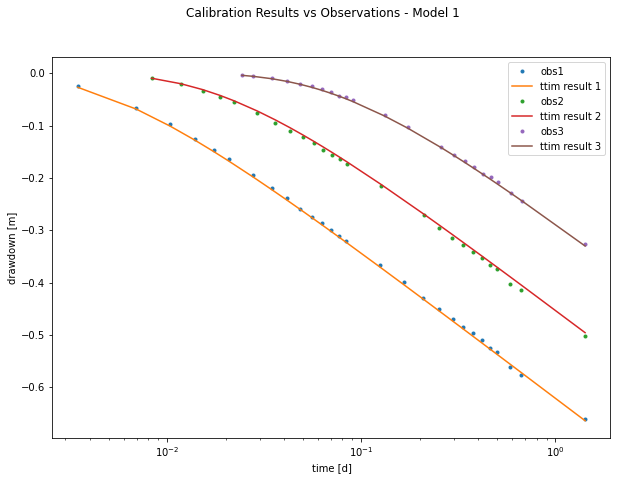

In [8]:
hm1_0 = ml_0.head(x = r1, y = 0,t = t1)
hm2_0 = ml_0.head(x = r2, y = 0, t = t2)
hm3_0 = ml_0.head(x = r3, y = 0, t = t3)
plt.figure(figsize = (10, 7))
plt.semilogx(t1, h1, '.', label='obs1')
plt.semilogx(t1, hm1_0[0], label='ttim result 1')
plt.semilogx(t2, h2, '.', label='obs2')
plt.semilogx(t2, hm2_0[0], label='ttim result 2')
plt.semilogx(t3, h3, '.', label='obs3')
plt.semilogx(t3, hm3_0[0], label='ttim result 3')
plt.xlabel('time [d]')
plt.ylabel('drawdown [m]')
plt.legend()
plt.suptitle('Calibration Results vs Observations - Model 1');

Visually, the model seems to have a good fit with the data

### Step 5.2. Model Calibration with skin resistance and wellbore storage

In this new model, we investigate whether the well parameters are relevant in the fit.

We begin by reloading the model and creating a ```Well``` object with two extra parameters:

* The radius of the caisson ```rc```, which we use to simulate wellbore storage. In this case, we use a value in meters (float);
* The skin resistance ```res```, a float value with the unit in days.

In [9]:
ml_1 = ModelMaq(kaq=10, z=[0, b], Saq=0.001, tmin=0.001, tmax=10, topboundary='conf')
w_1 = Well(ml_1, xw=0, yw=0, rw=rw, rc=0, res=0, tsandQ=[(0, Q)], layers=0)
ml_1.solve()

self.neq  1
solution complete


Here we use the method ```.set_parameter_by_reference``` to calibrate the ```rc``` and ```res``` parameters in our well.

```.set_parameter_by_reference``` takes the following arguments:
* ```name```: a string of the parameter name
* ```parameter```: numpy-array with the parameter to be optimized. It should be specified as a reference, for example, in our case: ```w1.rc[0:]``` referencing to the parameter ```rc``` in object ```w1```.
* ```initial```: float with the initial guess for the parameter value.
* ```pmin``` and ```pmax```: floats with the minimum and maximum values allowed. If not specified, these will be ```-np.inf``` and ```np.inf```.

In [10]:
#unknown parameters: k, Saq, res, rc
ca_1 = Calibrate(ml_1)
ca_1.set_parameter(name='kaq0', initial=10)
ca_1.set_parameter(name='Saq0', initial=1e-4)
ca_1.set_parameter_by_reference(name='res', parameter=w_1.res, initial=0, pmin = 0)
ca_1.set_parameter_by_reference(name='rc', parameter=w_1.rc, initial=0)
ca_1.series(name='obs1', x=r1, y=0, t=t1, h=h1, layer=0)
ca_1.series(name='obs2', x=r2, y=0, t=t2, h=h2, layer=0)
ca_1.series(name='obs3', x=r3, y=0, t=t3, h=h3, layer=0)
ca_1.fit(report=True)

..............................................................................................................................................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 155
    # data points      = 77
    # variables        = 4
    chi-square         = 0.16728902
    reduced chi-square = 0.00229163
    Akaike info crit   = -464.151505
    Bayesian info crit = -454.776283
[[Variables]]
    kaq0:  273.005026 +/- 15.1160207 (5.54%) (init = 10)
    Saq0:  0.00255964 +/- 4.2817e-04 (16.73%) (init = 0.0001)
    res:   1.4282e-09 +/- 8.9517e-06 (626797.94%) (init = 0)
    rc:    6.77695229 +/- 0.71794625 (10.59%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0, Saq0) = -0.854
    C(Saq0, rc)   = -0.787
    C(kaq0, rc)   =  0.562
    C(kaq0, res)  = -0.133
    C(res, rc)    =  0.118


In [11]:
display(ca_1.parameters)
print('RMSE:', ca_1.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,273.005026,15.116021,5.536902,-inf,inf,10,[273.00502627116214]
Saq0,0.00256,0.000428,16.727814,-inf,inf,0.0001,[0.002559641535266795]
res,0.0,0.000009,626797.940374,0.0,inf,0,[1.4281609228561365e-09]
rc,6.776952,0.717946,10.59394,-inf,inf,0,[6.7769522871728745]


RMSE: 0.04661099302703189


When adding both res and rc into calibration, the optimized res value is very close to 0. Moreover, the standard deviation is way above any reasonable limit. Thus, adding res has nearly no effect on improving the conceptual model's performance. Therefore, ```res``` is removed from the calibration.

In [12]:
#unknown parameters: k, Saq, res, rc
ca_1 = Calibrate(ml_1)
ca_1.set_parameter(name='kaq0', initial=10)
ca_1.set_parameter(name='Saq0', initial=1e-4)
#ca_1.set_parameter_by_reference(name='res', parameter=w_1.res, initial=0, pmin = 0)
ca_1.set_parameter_by_reference(name='rc', parameter=w_1.rc, initial=0)
ca_1.series(name='obs1', x=r1, y=0, t=t1, h=h1, layer=0)
ca_1.series(name='obs2', x=r2, y=0, t=t2, h=h2, layer=0)
ca_1.series(name='obs3', x=r3, y=0, t=t3, h=h3, layer=0)
ca_1.fit(report=True)

..............................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 77
    # variables        = 3
    chi-square         = 0.00116245
    reduced chi-square = 1.5709e-05
    Akaike info crit   = -848.779368
    Bayesian info crit = -841.747952
[[Variables]]
    kaq0:  283.922420 +/- 1.28512972 (0.45%) (init = 10)
    Saq0:  0.00415479 +/- 4.3873e-05 (1.06%) (init = 0.0001)
    rc:    0.78984701 +/- 0.21258079 (26.91%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0, Saq0) = -0.852
    C(Saq0, rc)   = -0.669
    C(kaq0, rc)   =  0.487


In [13]:
display(ca_1.parameters)
print('RMSE:', ca_1.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,283.92242,1.285130,0.452634,-inf,inf,10,[283.9224200948205]
Saq0,0.004155,0.000044,1.055952,-inf,inf,0.0001,[0.004154791313161871]
rc,0.789847,0.212581,26.914173,-inf,inf,0,[0.7898470102682342]


RMSE: 0.0038854542453351476


The new model has better statistics: lower AIC and BIC, lower RMSE and lower standard deviations for hydraulic conductivities and specific storage. We proceed with plotting the results:

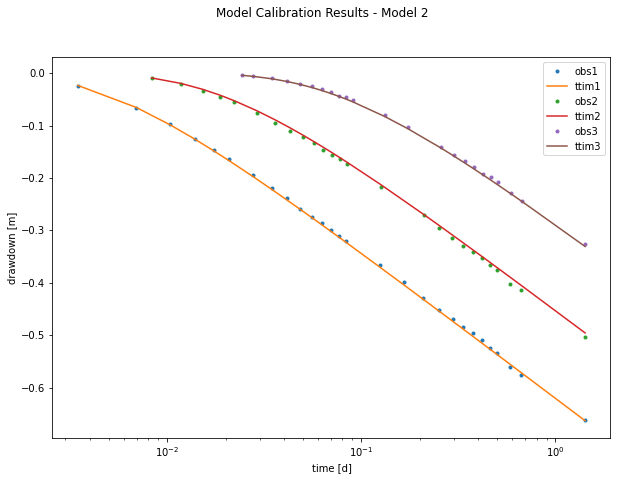

In [14]:
hm1_1 = ml_1.head(r1, 0, t1)
hm2_1 = ml_1.head(r2, 0, t2)
hm3_1 = ml_1.head(r3, 0, t3)
plt.figure(figsize = (10, 7))
plt.semilogx(t1, h1, '.', label='obs1')
plt.semilogx(t1, hm1_1[0], label='ttim1')
plt.semilogx(t2, h2, '.', label='obs2')
plt.semilogx(t2, hm2_1[0], label='ttim2')
plt.semilogx(t3, h3, '.', label='obs3')
plt.semilogx(t3, hm3_1[0], label='ttim3')
plt.xlabel('time [d]')
plt.ylabel('drawdown [m]')
plt.legend()
plt.suptitle('Model Calibration Results - Model 2');

From the plot above, we can see that there is good agreement between the model calculated heads and the observed ones for all observation wells

## Step 6. Analysis of Results

### Step 6.1. Analysis of Fit Statistics

Some of the fit statistics are stored in the ```fitresult``` attribute of the calibration object. This object is a lmfit ```MinimizerResult``` object. ```lmfit``` is the python library doing the calibration for TTim behind the scenes. We accessed below the AIC and BIC values of this object.

Check the lmfit documentation (Newville et al. 2014) to learn more about this object and lmfit.

In [15]:
t = pd.DataFrame(columns = ['RMSE', 'AIC', 'BIC','Calibration scheme'], index = ['Model 1', 'Model 2'])

t['RMSE'] = [ca_0.rmse(), ca_1.rmse()]

t['AIC'] = [ca_0.fitresult.aic, ca_1.fitresult.aic]

t['BIC'] = [ca_0.fitresult.bic, ca_1.fitresult.bic]

t['Calibration scheme'] = ["All Obs Wells", "All Obs Wells + wellbore storage"]
t.style.set_caption("Fit statistics for the tested models")

,RMSE,AIC,BIC,Calibration scheme
Model 1,0.003974,-847.289973,-842.602362,All Obs Wells
Model 2,0.003885,-848.779368,-841.747952,All Obs Wells + wellbore storage


The fit statistics show that the models have very similar performance as all indicators are closely related. By RMSE and AIC criteria, we should pick Model 2, while by BIC, we should pick Model 1. The result means that we cannot exclude one model in favour of the other.

### Step 6.2. Summary of Calibrated Parameters and comparison with different Software solutions

We present the results simulated in TTim under different configurations below. Furthermore, Yang (2020) compared TTim results with the results obtained from the software AQTESOLV (Duffield, 2007) and MLU (Carlson & Randall, 2012). In both software, the model was calibrated with observations.

In [16]:
t = pd.DataFrame(columns=['k [m/d]', 'Ss [1/m]', 'rc'], \
                index=['AQTESOLV', 'MLU', 'ttim', 'ttim-rc'])
t.loc['AQTESOLV'] = [282.659, 4.211E-03, '-']
t.loc['ttim'] = np.append(ca_0.parameters['optimal'].values, '-')
t.loc['ttim-rc'] = ca_1.parameters['optimal'].values
t.loc['MLU'] = [282.684, 4.209e-03, '-']
t['RMSE'] = [0.003925, 0.003897, ca_0.rmse(), ca_1.rmse()]
t

,k [m/d],Ss [1/m],rc,RMSE
AQTESOLV,282.659,0.004211,-,0.003925
MLU,282.684,0.004209,-,0.003897
ttim,282.795267,0.004209,-,0.003974
ttim-rc,283.92242,0.004155,0.789847,0.003885


TTim achieved similar results with the other software. The TTim model with wellbore storage had a slightly better RMSE error.

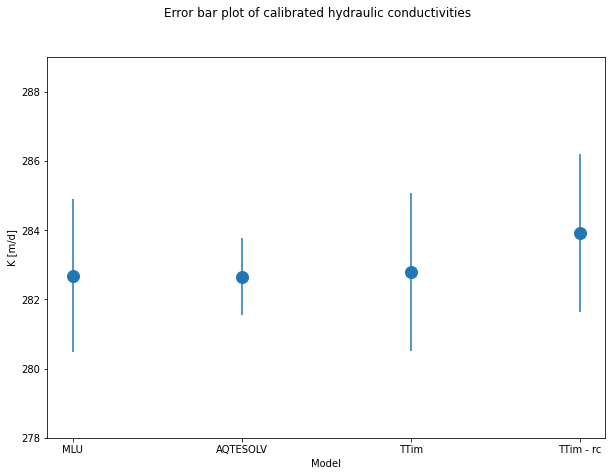

In [17]:
# Preparing the DataFrame:
t1 = pd.DataFrame(columns=['kaq - opt', 'kaq - 95%'], index = ['MLU','AQTESOLV','TTim','TTim - rc']) 
simulation = ['MLU','AQTESOLV','TTim','TTim - rc']
t1.loc['MLU'] = [282.684, 0.783*1e-2*282.6842]
t1.loc['AQTESOLV'] = [282.659, 0.394*1e-2*282.659]
t1.loc['TTim'] = [ca_0.parameters.loc['kaq0','optimal'],2*ca_0.parameters.loc['kaq0','std']]
t1.loc['TTim - rc'] = [ca_1.parameters.loc['kaq0','optimal'],2*ca_0.parameters.loc['kaq0','std']]

# Plotting

plt.figure(figsize = (10,7))

plt.errorbar(x = t1.index, y = t1['kaq - opt'], yerr = [t1['kaq - 95%'], t1['kaq - 95%']],
    marker='o', linestyle='', markersize=12)
#plt.legend()
plt.suptitle("Error bar plot of calibrated hydraulic conductivities")
plt.ylabel('K [m/d]')
plt.ylim([278,289])
plt.xlabel('Model');

Error bar plot shows AQTESOLV with the lowest confidence interval. The models in TTim have larger confidence intervals. However, they are still small. All models seem to agree, and there is a wide overlap in the confidence intervals for hydraulic conductivity

## References

* Carlson F, Randall J (2012) MLU: a Windows application for the analysis of aquifer tests and the design of well fields in layered systems. Ground Water 50(4):504–510
* Duffield, G.M., 2007. AQTESOLV for Windows Version 4.5 User's Guide, HydroSOLVE, Inc., Reston, VA.
* Newville, M.,Stensitzki, T., Allen, D.B., Ingargiola, A. (2014) LMFIT: Non Linear Least-Squares Minimization and Curve Fitting for Python.https://dx.doi.org/10.5281/zenodo.11813. https://lmfit.github.io/lmfit-py/intro.html (last access: August,2021).
* Yang, Xinzhu (2020) Application and comparison of different methodsfor aquifer test analysis using TTim. Master Thesis, Delft University of Technology (TUDelft), Delft, The Netherlands.

#### Next Notebook: [Confined 4 - Schroth](confined4_schroth.ipynb)